# GCC's ssc-cdi : tomography pipeline for Cateretê v0.1
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [1]:
%matplotlib widget
import numpy as np, matplotlib.pyplot as plt, json
import sscInstall
import sscCdi

print(f'sscCdi version: {sscCdi.__version__}')

sscCdi version: 0.5.1


## Load dictionary

In [2]:
dic = {}

In [3]:
# dic = json.load(open('/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/CAT_tomo_inputs.json'))
dic['processing_steps'] = {}
dic['processing_steps']['read'] = True
dic['processing_steps']['sort'] = True
dic['processing_steps']['crop'] = True
dic['processing_steps']['equalize2D'] = True
dic['processing_steps']['unwrap'] = True
dic['processing_steps']['alignment'] = True
dic['processing_steps']['tomography'] = True
dic['processing_steps']['equalize3D'] = True
# dic

# Run at Cluster

In [35]:
server = sscInstall.connect_server()  

Username: yuri.tonin


Password:


 ········


In [5]:
json_filepath_path = sscCdi.cat_ptycho_processing.save_input_dictionary(dic)
sscCdi.run_at_cluster(server,json_filepath_path,queue='cat',gpus=dic["GPUs"],cpus=dic["CPUs"],jobName='job',script_path = "/ibira/lnls/labs/tepui/home/yuri.tonin/ssc-cdi/bin/caterete_tomo.py",slurm_path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/')

# Run Locally

## Load data

In [6]:
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "phase" # phase or magnitude
dic["sinogram_path"] = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/2023-05-16-15h38m_glass_sphere.hdf5"

In [7]:
dic = sscCdi.define_paths(dic)

In [8]:
obj, angles = sscCdi.read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

Object shape = (214, 3479, 3479) 	 Number of angles: (214, 2)


In [9]:
sscCdi.deploy_visualizer(obj,title='Original sinogram',cmap='gray')

In [10]:
crop = obj[:,1500:-1400,1400:-1500]
sscCdi.deploy_visualizer(crop,title='Original sinogram',cmap='gray')

## Sort data

In [11]:
sscCdi.tomo_sort(dic,obj, angles)

Time elapsed: 8.48 s


In [12]:
sscCdi.deploy_visualizer(np.load(dic["ordered_object_filepath"]),title="Ordered sinogram",cmap='gray')

In [13]:
dic["top_crop"]    = 1500
dic["bottom_crop"] = 1400
dic["left_crop"]   = 1400
dic["right_crop"]  = 1500

In [14]:
sscCdi.tomo_crop(dic)

Cropped sinogram shape: (214, 579, 579)
Time elapsed: 5.55 s


In [15]:
sscCdi.deploy_visualizer(np.load(dic["cropped_sinogram_filepath"]),title="Cropped sinogram",cmap='gray')

## Unwrap

In [16]:
dic["bad_frames_before_unwrap"] = [28,30,45,49,65,66,91,113]

In [17]:
sscCdi.tomo_unwrap(dic)

Using 32 parallel processes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:02<00:00, 78.92it/s]


Time elapsed: 4.14 s


In [18]:
sscCdi.deploy_visualizer(np.load(dic["unwrapped_sinogram_filepath"]),title="Unwrapped sinogram",cmap='gray')

## 2D Equalization

In [19]:
dic["sinogram_to_equalize"] = 'unwrapped' # cropped or unwrapped
dic["bad_frames_before_equalization"] = []
dic["equalize_gradient"] = True
dic["equalize_global_offset"] = False
dic["equalize_invert"] = True
dic["equalize_local_offset"] = [0,50,0,50]
dic["equalize_outliers"] = 0

In [20]:
sscCdi.tomo_equalize(dic)

Sinogram shape to unwrap:  (214, 579, 579)
Using 32 parallel processes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:06<00:00, 32.16it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  0.0 -3.6074194572404017 0.6918467435562231 4.991112944352848 5.428686880720798
New  0.0 -4.462309718132019 0.97892106 6.4201518297195435 8.264117
Time elapsed: 8.18 s


In [21]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray')

In [22]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto')#,limits=(0,0.5))

## Alignment

In [23]:
dic["wiggle_sinogram_selection"] = dic["equalized_sinogram_filepath"]
dic["step_percentage"] = 0 # need to project irregular angle steps to a regular grid?

In [24]:
sscCdi.preview_angle_projection(dic)

Simulating projection of angles to regular grid...
Before+after frames added: 59
Intermediate null frames : 105
                        + -----
Total null frames        : 164
Frames being used        : 214  of  214
                        + -----
Projected Angles         : 378


In [25]:
dic["CPUs"] = 64
dic["project_angles_to_regular_grid"] = True
dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 0

In [26]:
dic = sscCdi.tomo_alignment(dic)

ssc-radon: creating 378x579x579 shared arrays (tomogram)
ssc-radon: creating 378x579x579 shared arrays (tomogram)
	Finished vertical wiggle. Starting horizontal wiggle...
ssc-radon: creating 378x579x579 shared arrays (tomogram)
Time elapsed: 8.51 s


In [27]:
sscCdi.deploy_visualizer(np.load(dic["wiggle_sinogram_filepath"]),title="Aligned sinogram",cmap='gray',axis=1)

## Tomography

In [28]:
dic["GPUs"] = [0,1]
dic["tomo_algorithm"] = "EEM"
dic["tomo_iterations"] = 10
dic["tomo_regularization_param"] = 0 # if != 0, do regularization. Recommended = 0.001

In [29]:
recon3D = sscCdi.tomo_recon(dic)

Starting tomographic algorithm EEM with 10 iterations
EM param: 20 [10, 3, 8] 0.0001 1e-15 eEM 378 [0, 1] 579 579
	Applying wiggle center-of-mass correction to 3D reconstructed slices...
ssc-radon: creating 579x579x579 shared arrays (tomogram)
	 Tomography done!
Saving tomography logfile...
	Saved!
Time elapsed: Tomography: 9.82306170463562 s


In [30]:
sscCdi.deploy_visualizer(np.load(dic["reconstruction_filepath"]),title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

## 3D Equalization

In [31]:
dic["tomo_remove_outliers"] = 0
dic["tomo_threshold"] = 15.0
dic["tomo_local_offset"] = []
dic["tomo_mask"] = []

In [32]:
sscCdi.tomo_equalize3D(dic)

Time elapsed: 1.33 s


In [33]:
sscCdi.deploy_visualizer(np.load(dic["eq_reconstruction_filepath"]),title="Equalized Recon",cmap='gray',axis=0)

Original data statistics:  
	Max = 3.27e+00
	 Min = -9.53e-02
	 Mean = 2.52e-01
	 StdDev = 6.87e-01
Thresholded data statistics:  
	Max = 3.27e+00
	 Min = -9.53e-02
	 Mean = 2.52e-01
	 StdDev = 6.87e-01


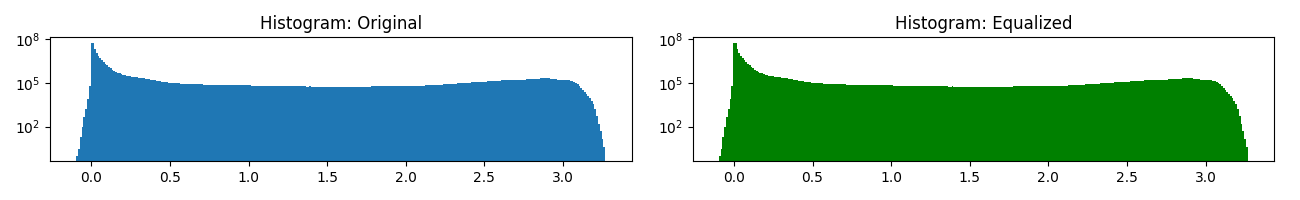

In [34]:
equalized_tomogram = np.load(dic["eq_reconstruction_filepath"])
sscCdi.plot_histograms(recon3D, equalized_tomogram,bins=300)